In [ ]:
import os
import urllib.request
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
filepath = "../data/names.txt"

os.makedirs("../data", exist_ok=True)

if not os.path.exists(filepath):
    print(f"Downloading {filepath}...")
    urllib.request.urlretrieve(url, filepath)
    print("Done!")
else:
    print(f"{filepath} already exists.")

words = open(filepath, 'r').read().splitlines()
print(f"Loaded {len(words)} words")

data/names.txt already exists.
Loaded 32033 words


In [217]:
chars = ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

In [218]:
# traning split, dev/validation split, test split
# 80% training, 10% dev, 10% test

# build the dataset

block_size = 3 # context lenght: how many characters do we take to predict the next one?
def build_dataset(words):

	X, Y = [], []

	# for w in words[:5]:
	for w in words:
		
		# print(w)
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			# print(''.join(itos[i] for i in context), '->', itos[ix])
			context = context[1:] + [ix]

	X = torch.tensor(X)
	Y = torch.tensor(Y)

	return X, Y

import random
random.shuffle(words)
n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [219]:
g = torch.manual_seed(2147483647)

emb_dims = 10
C = torch.randn((27, emb_dims), generator=g)

print(C[Xtrain].shape)

print(Xtrain.shape)

print(Xtrain[13], '->', ''.join(itos[i] for i in Xtrain[13].tolist()))
print(Xtrain[13,2])

print(C[Xtrain][13,2])

print(C[1])

torch.Size([182599, 3, 10])
torch.Size([182599, 3])
tensor([12,  5, 25]) -> ley
tensor(25)
tensor([-1.2801,  0.0924,  0.1053, -0.3907,  0.0317, -0.5475,  0.8183, -0.8163,
        -0.3924, -0.7452])
tensor([-0.4713,  0.7868, -0.3284, -0.4330,  1.3729,  2.9334,  1.5618, -1.6261,
         0.6772, -0.8404])


In [220]:
# forward pass

neurons = 200
W1 = torch.randn((emb_dims * block_size, neurons), generator=g)
b1 = torch.randn((neurons), generator=g)
W2 = torch.randn((neurons, 27), generator=g)
b2 = torch.randn((27), generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
	p.requires_grad = True

lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

lri = []
lossi = []
stepi = []


In [221]:
def learn(runs, learning_rate):

	for i in range(runs):

		# mini-batch of 32 random examples
		ix = torch.randint(0, Xtrain.shape[0], (32,))

		emb = C[Xtrain[ix]] # 32, 3, 2
		h = torch.tanh(emb.view(-1, emb_dims * block_size) @ W1 + b1) # 32, 100

		logits = h @ W2 + b2 # 32, 27

		# # loss function
		# counts = logits.exp()
		# probs = counts / counts.sum(1, keepdim=True)
		# print(probs.shape)
		# print(Y[ix])
		# print(-probs[torch.arange(32), Y[ix]].log().mean())

		# efficient implementation of the loss, fused kernel
		loss = F.cross_entropy(logits, Ytrain[ix])
		# print(loss)

		# backward pass

		for p in parameters:
			p.grad = None
		
		loss.backward()

		#### lr = lrs[i]
		lr = learning_rate
		for p in parameters:
			p.data -= p.grad * lr

		# # store the loss and learning rate
		### lri.append(lre[i])
		stepi.append(i)
		lossi.append(loss.log10().item())

	print(loss.item())

	emb = C[Xtrain] # 32, 3, 2
	h = torch.tanh(emb.view(-1, emb_dims * block_size) @ W1 + b1) # 32, 100
	logits = h @ W2 + b2 # 32, 27
	loss = F.cross_entropy(logits, Ytrain)
	print(loss)

	emb = C[Xdev] # 32, 3, 2
	h = torch.tanh(emb.view(-1, emb_dims * block_size) @ W1 + b1) # 32, 100
	logits = h @ W2 + b2 # 32, 27
	loss = F.cross_entropy(logits, Ydev)
	print(loss)

learn(runs=50000, learning_rate=0.1)
learn(runs=50000, learning_rate=0.01)

2.4070489406585693
tensor(2.3393, grad_fn=<NllLossBackward0>)
tensor(2.3642, grad_fn=<NllLossBackward0>)
2.097435712814331
tensor(2.1771, grad_fn=<NllLossBackward0>)
tensor(2.2036, grad_fn=<NllLossBackward0>)


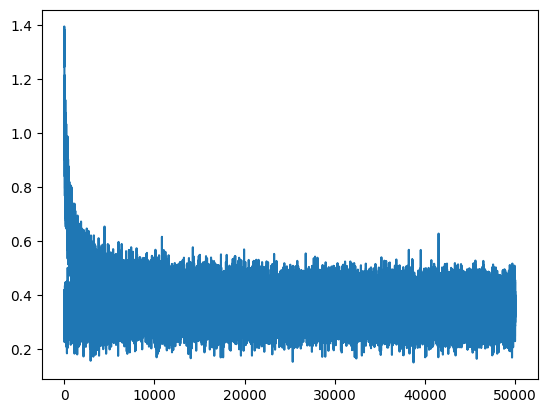

In [222]:
plt.plot(stepi, lossi)
# plt.plot(lri, lossi)

In [232]:
for _ in range(20):
	out = []

	context = [0] * block_size
	while True:
		emb = C[torch.tensor([context])] # 1, block_size, emb_dims
		# h = torch.tanh(emb.view(-1, emb_dims * block_size) @ W1 + b1) # 1, neurons
		h = torch.tanh(emb.view(1, -1) @ W1 + b1) # 1, neurons
		logits = h @ W2 + b2 # 1, 27
		probs = F.softmax(logits, dim=-1)
		ix = torch.multinomial(probs, num_samples=1, generator=g).item()
		context = context[1:] + [ix]
		out.append(itos[ix])
		if ix == 0:
			break
	print(''.join(out))


elinna.
coryankil.
thyagya.
poanton.
celdorris.
lavieghlie.
chy.
shi.
nondo.
nihvaan.
maliah.
neched.
leryn.
bair.
avy.
rythinia.
tamaulum.
khnbin.
surgin.
sha.


In [ ]:
# # visualize dimensions 0 and 1 of the embedding matrix C for all characters
# plt.figure(figsize=(8,8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

**Why doesn't changing `offset` affect the probabilities?**

This demonstrates the **shift invariance** property of softmax. When you subtract a constant $c$ from all logits, the probabilities remain unchanged:

$$P(i) = \frac{e^{x_i - c}}{\sum e^{x_j - c}} = \frac{e^{x_i} \cdot e^{-c}}{e^{-c} \cdot \sum e^{x_j}} = \frac{e^{x_i}}{\sum e^{x_j}}$$

The $e^{-c}$ factor appears in both numerator and denominator, so it cancels out.

This property is useful for **numerical stability** — subtracting `max(logits)` prevents overflow when exponentiating large values, without changing the result.


In [224]:
def invariance_property(offset=0):
    logits = torch.tensor([-5,-3,0,100]) - offset
    counts = logits.exp()
    probs = counts / counts.sum()
    print(probs)
invariance_property(offset=0)
invariance_property(offset=100)

tensor([0., 0., 0., nan])
tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])
